# Predict INTC index 1
## Follow this tutorial https://www.tensorflow.org/tutorials/structured_data/time_series#part_1_forecast_a_univariate_time_series

In [12]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import yfinance as yf
import pandas_datareader.data as pdr
import time
yf.pdr_override()

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
csv_path = 'stock_prices.csv'

In [105]:
all_data = pdr.get_data_yahoo("INTC", period='12mo', interval="60m")
all_data.to_csv(csv_path)

[*********************100%***********************]  1 of 1 completed


In [110]:
column = 'Adj Close'

df = pd.read_csv(csv_path)
date_time = pd.to_datetime(df.pop('Datetime'))
df

,Open,High,Low,Close,Adj Close,Volume
0,52.090000,52.299999,51.573299,51.590000,51.590000,3365378
1,51.590000,52.095001,51.430000,52.095001,52.095001,2575687
2,52.099998,52.380001,52.060001,52.259998,52.259998,3012334
3,52.255001,52.334999,52.070000,52.320000,52.320000,1990278
4,52.314999,52.430000,52.290001,52.363300,52.363300,2093101
...,...,...,...,...,...,...
1759,47.895000,48.130001,47.790001,48.130001,48.130001,9467008
1760,48.130001,48.270000,47.910000,48.055000,48.055000,7971636
1761,48.049999,48.119999,47.974998,48.060001,48.060001,5088307
1762,48.060001,48.090000,47.930000,48.013699,48.013699,6310866


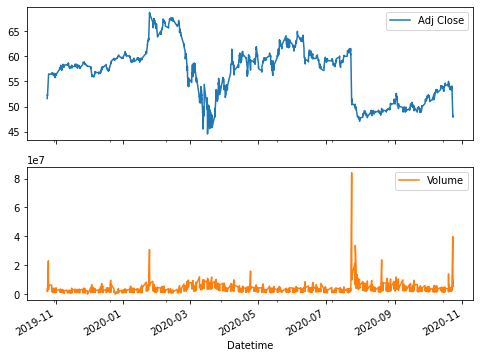

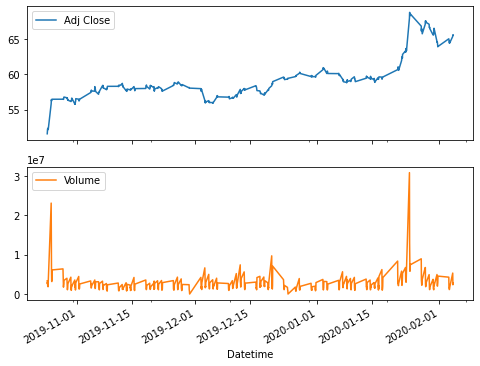

In [107]:
plot_cols = ['Adj Close', 'Volume']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [108]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,1764.0,5.680805e+01,5.219782e+00,45.570000,5.224075e+01,5.791350e+01,5.988375e+01,6.870000e+01
High,1764.0,5.708274e+01,5.182010e+00,47.150002,5.251500e+01,5.815750e+01,6.013465e+01,6.929000e+01
Low,1764.0,5.653330e+01,5.256720e+00,43.630001,5.192595e+01,5.769500e+01,5.966125e+01,6.849000e+01
Close,1764.0,5.681393e+01,5.218459e+00,44.544998,5.224875e+01,5.791750e+01,5.989250e+01,6.871000e+01
Adj Close,1764.0,5.681393e+01,5.218459e+00,44.544998,5.224875e+01,5.791750e+01,5.989250e+01,6.871000e+01
Volume,1764.0,3.303167e+06,3.287681e+06,0.000000,1.746371e+06,2.574061e+06,3.919363e+06,8.395446e+07


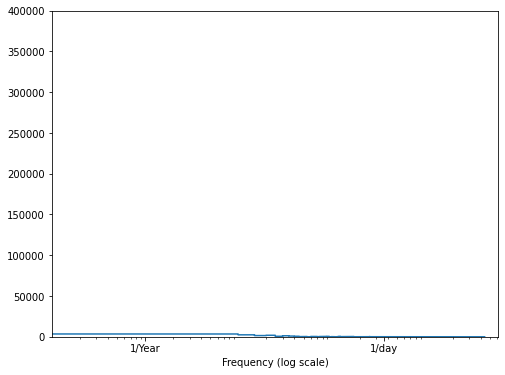

In [109]:
fft = tf.signal.rfft(df[column])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df[column])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

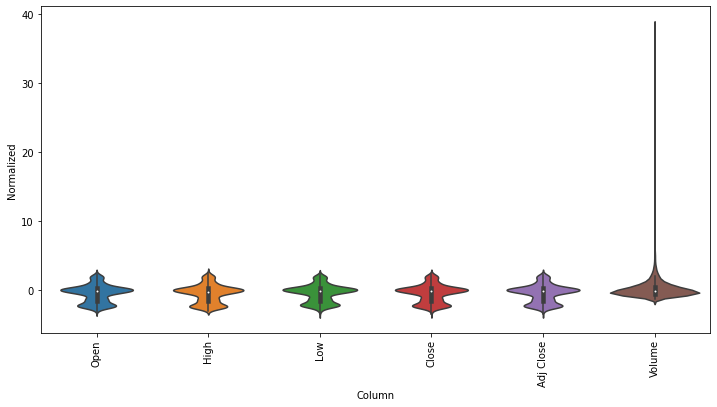

In [123]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [116]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col=None, max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(3, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [64]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=[column])
w1

w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=[column])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['High']

In [82]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 6)
Inputs shape: (3, 6, 6)
labels shape: (3, 1, 1)


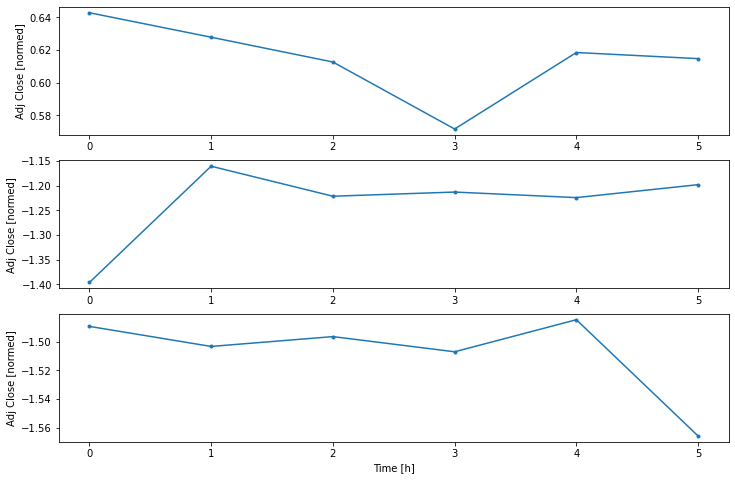

In [83]:
w2.plot(plot_col=column)

In [68]:
# Each element is an (inputs, label) pair
w2.train.element_spec

for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 6)
Labels shape (batch, time, features): (32, 1, 1)


In [84]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[column])

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=[column])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Adj Close']

6/6 [==============================] - 0s 666us/step - loss: 0.0036 - mean_absolute_error: 0.0444


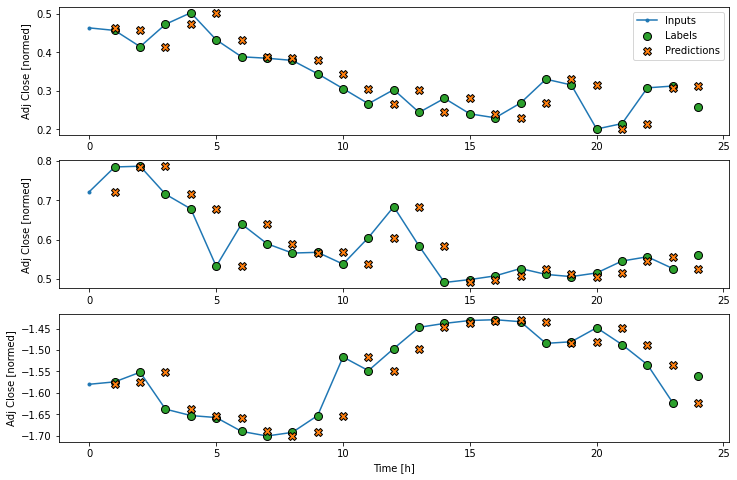

In [85]:
baseline = Baseline(label_index=column_indices[column])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

wide_window.plot(baseline, plot_col=column)

In [87]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 6)
Output shape: (32, 1, 1)


In [88]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
20/20 [==============================] - 0s 6ms/step - loss: 4.2967 - mean_absolute_error: 1.7877 - val_loss: 6.3849 - val_mean_absolute_error: 2.4896
Epoch 2/20
20/20 [==============================] - 0s 3ms/step - loss: 3.9008 - mean_absolute_error: 1.7002 - val_loss: 5.8150 - val_mean_absolute_error: 2.3753
Epoch 3/20
20/20 [==============================] - 0s 3ms/step - loss: 3.5351 - mean_absolute_error: 1.6159 - val_loss: 5.2664 - val_mean_absolute_error: 2.2597
Epoch 4/20
20/20 [==============================] - 0s 3ms/step - loss: 3.1971 - mean_absolute_error: 1.5336 - val_loss: 4.7675 - val_mean_absolute_error: 2.1492
Epoch 5/20
20/20 [==============================] - 0s 3ms/step - loss: 2.8850 - mean_absolute_error: 1.4546 - val_loss: 4.2955 - val_mean_absolute_error: 2.0393
Epoch 6/20
20/20 [==============================] - 0s 3ms/step - loss: 2.6014 - mean_absolute_error: 1.3781 - val_loss: 3.8665 - val_mean_absolute_error: 1.9339
Epoch 7/20
20/20 [==========

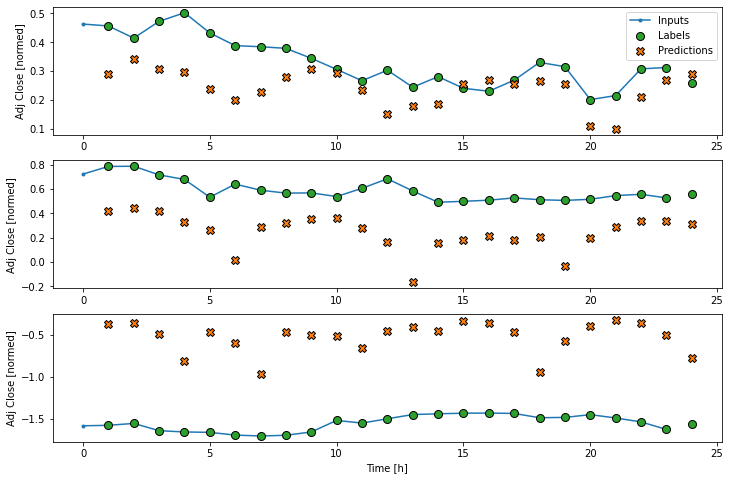

In [90]:
wide_window.plot(linear, plot_col=column)

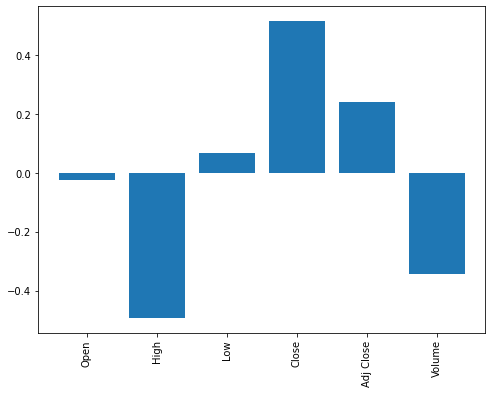

In [91]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

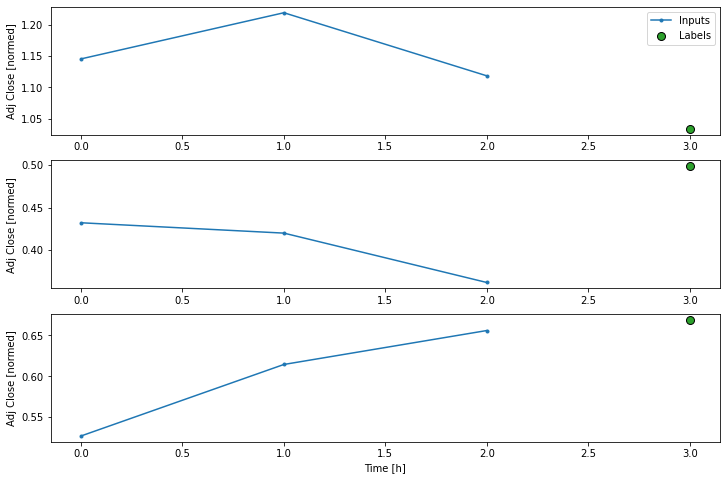

In [94]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=[column])

conv_window.plot(plot_col=column)

In [95]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

6/6 [==============================] - 0s 997us/step - loss: 0.0061 - mean_absolute_error: 0.0611


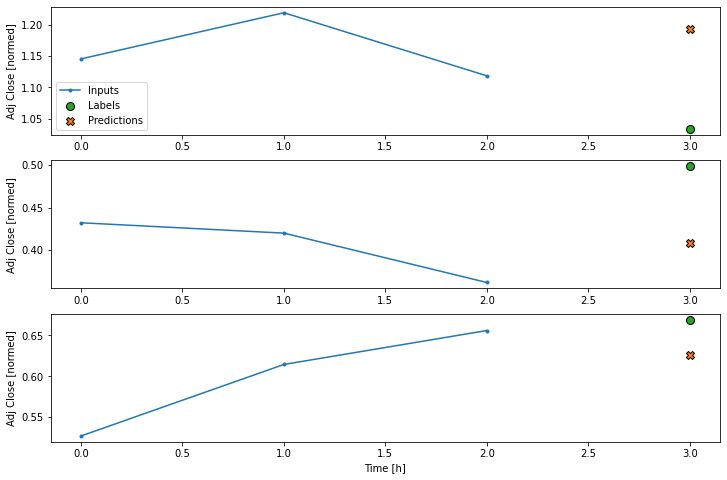

In [97]:
conv_window.plot(multi_step_dense, plot_col=column)

5/5 [==============================] - 0s 2ms/step - loss: 0.0231 - mean_absolute_error: 0.1051


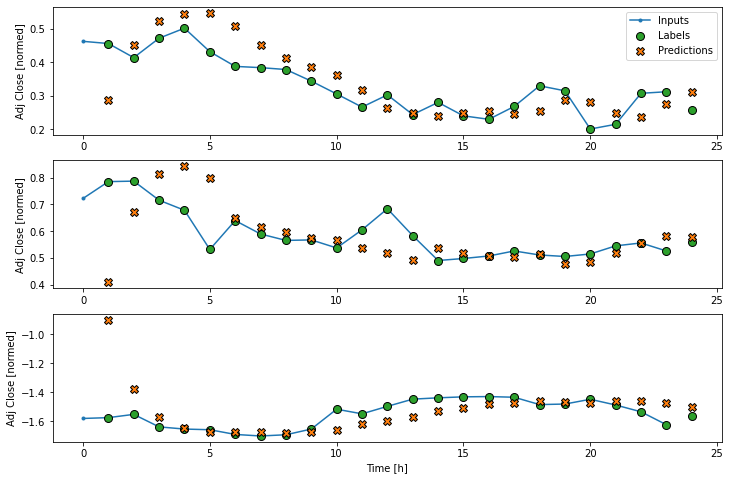

In [101]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)
wide_window.plot(lstm_model, plot_col=column)

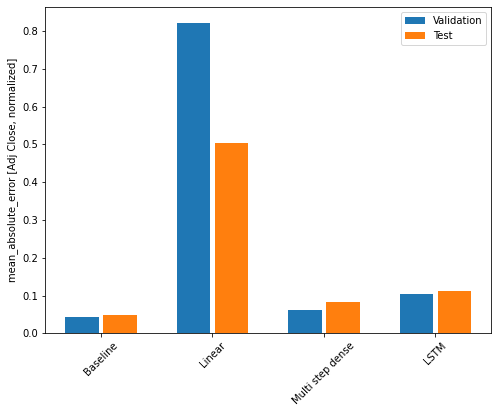

In [102]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel(f'mean_absolute_error [{column}, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [103]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0482
Linear      : 0.5023
Multi step dense: 0.0836
LSTM        : 0.1126
